In [1]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot

PyPlot

### Let's start off by verifying that we can still handle single-photon processes in a simple way.

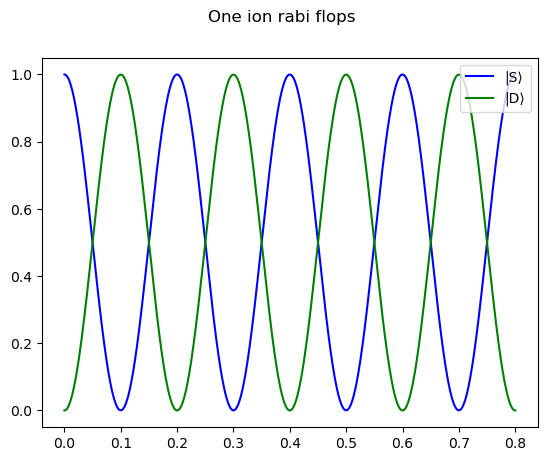

In [2]:
#two-level ion, S and D
my_ion = Ca40([("S1/2", -1/2), ("D5/2", -1/2)])
set_sublevel_alias!(my_ion, Dict("S" => ("S1/2", -1/2), "D" => ("D5/2", -1/2)))

#one motional mode
νr = 4e6  #including this so that the chain can have com freqs
νa = 1e6
#one laser
my_laser = Laser()
my_laser.k = ẑ
my_laser.ϵ = ẑ
my_laser.ϕ = 0

#configure trap
B = 4e-4
my_chain = LinearChain(ions=[my_ion], com_frequencies=(x=νr, y=νr, z=νa), vibrational_modes=(z=[1],))
my_trap = Trap(configuration=my_chain, B=B, Bhat=ẑ, δB=0, lasers=[my_laser])

#set laser wavelength and power
my_laser.λ = transitionwavelength(my_ion,("S","D"),my_trap)
my_laser.Δ = 0.1e6
Ω = 50e5 #rabi frequency - not an angular frequency!
Efield_from_rabi_frequency!(Ω, my_trap, 1, 1, ("S", "D"));

#set up axial mode
axial = my_trap.configuration.vibrational_modes.z[1]
axial.N = 0

# set initial state |S⟩ ⊗ |0⟩
ψi = my_ion["S"]
ρi_ions = dm(ψi)
ρi_axial = dm(fockstate(axial, 0))
ρi = ρi_ions ⊗ ρi_axial

J = one(dm(ψi)) ⊗ one(axial)
γ = 1

c = 299792458

#=unitary should be a vector of vectors of tuples so that
    u[j][k][1] is the kth "rotated" sublevel of the jth ion, and
    u[j][k][2] is the angular frequency of that rotation. 

    u does not need to have an element for every sublevel in the ion, but it shouldn't be larger than the ion's 
    electronic hilbert space. =#

u = []#Vector{Vector{Tuple{Int64,Int64}}}


#=Let's go to the interaction picture so that we can handle our one-photon process. We can do it manually
or automatically. For starters, let's see how it is done manually. =#

ωs = 2π * energy(my_ion, "S", B = B, ignore_starkshift = true)
ωd = 2π * energy(my_ion, "D", B = B, ignore_starkshift = true)
x = [(("S1/2",-1/2),-ωs),(("D5/2",-1/2),-ωd)]
push!(u,x)

nflops = 4
τ = nflops/Ω*1e6
steps = 1000
tspan = 0:τ/steps:τ

#=Set the rwa cutoff to the laser detuning or more and we will see the dynamics.
This is because the interaction picture DOES NOT eliminate time dependence entirely, it just leaves
elements rotating at the laser detuning. It is possible to make a transformation in this case which
TOTALLY eliminates time dependence, and this would let us see dynamics even with rwa_cutoff=0! =#

h = hamiltonian(my_trap, rwa_cutoff=.1e6, lamb_dicke_order=2, u=u)
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h(t, ρ), [J], [J], [γ]))

slist = real(expect(ionprojector(my_trap,"S"),ρt))
dlist = real(expect(ionprojector(my_trap,"D"),ρt))
nlist = real(expect(one(ρi_ions)⊗IonSim.number(axial),ρt))

fig, (ax1) = plt.subplots(1)
fig.suptitle("One ion rabi flops")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
#ax2.plot(tspan,nlist,color="red",label="|n̄⟩")
ax1.legend(loc=1)
#ax2.legend(loc=1);

### Let's try the same thing, but this time use the hamiltonian_interaction_picture function instead of providing the rotating frame manually.

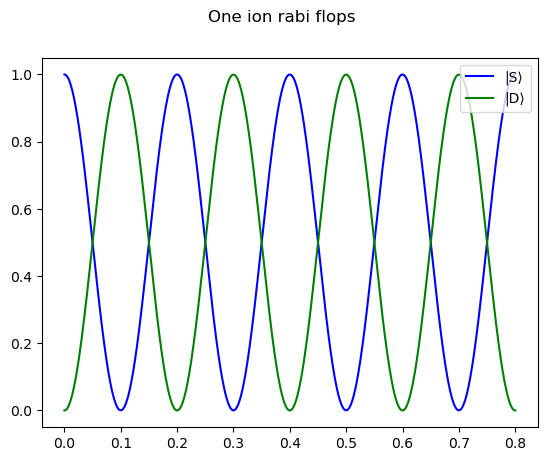

In [3]:
h_int = hamiltonian_interaction_picture(my_trap, rwa_cutoff=.1e6, lamb_dicke_order=2)
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h(t, ρ), [J], [J], [γ]))
slist = real(expect(ionprojector(my_trap,"S"),ρt))
dlist = real(expect(ionprojector(my_trap,"D"),ρt))
nlist = real(expect(one(ρi_ions)⊗IonSim.number(axial),ρt))

fig, (ax1) = plt.subplots(1)
fig.suptitle("One ion rabi flops")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
#ax2.plot(tspan,nlist,color="red",label="|n̄⟩")
ax1.legend(loc=1)
#ax2.legend(loc=1);

## Raman process??

In [4]:
my_ion = Ca40([("S1/2", -1/2), ("P3/2",-1/2),("D5/2", -1/2)])
set_sublevel_alias!(my_ion, Dict("S" => ("S1/2", -1/2), "P" => ("P3/2",-1/2),"D" => ("D5/2", -1/2)))
#one motional mode
νr = 4e6  #including this so that the chain can have com freqs
νa = 1e6
#two lasers
my_laser_1 = Laser()
my_laser_1.k = ẑ
my_laser_1.ϵ = ẑ
my_laser_1.ϕ = 0
my_laser_2 = Laser()
my_laser_2.k = ẑ
my_laser_2.ϵ = ẑ
my_laser_2.ϕ = 0

#configure trap
my_chain = LinearChain(ions=[my_ion], com_frequencies=(x=νr, y=νr, z=νa), vibrational_modes=(z=[1],))
my_trap = Trap(configuration=my_chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[my_laser_1,my_laser_2])

#set laser wavelength and power
Δ = 2π*300e6
δ = 0
my_laser_1.λ = transitionwavelength(my_ion,("S","P"),my_trap)
my_laser_1.Δ = Δ
my_laser_2.λ = transitionwavelength(my_ion,("D","P"),my_trap)
my_laser_2.Δ = Δ + δ

Ω₁ = 2π*1e6 #rabi frequency - not an angular frequency!
Ω₂ = 2π*1e6
Efield_from_rabi_frequency!(Ω₁, my_trap, 1, 1, ("S", "P"));
Efield_from_rabi_frequency!(Ω₂, my_trap, 2, 1, ("D", "P"));

#set up axial mode
axial = my_trap.configuration.vibrational_modes.z[1]
axial.N = 0

# set initial state |S⟩ ⊗ |0⟩
ψi = my_ion["S"]
ρi_ions = dm(ψi)
ρi_axial = dm(fockstate(axial, 0))
ρi = ρi_ions ⊗ ρi_axial

J = one(dm(ψi)) ⊗ one(axial)
γ = 1;

Ω_eff = Ω₁*Ω₂/Δ
nflops = 1
τ = nflops/Ω_eff
steps = 1000
tspan = 0:τ/steps:τ

#Let's go to the interaction picture!
u = []
ωs = 2π * energy(my_ion, "S", B = B, ignore_starkshift = true)
ωp = 2π * energy(my_ion, "P", B = B, ignore_starkshift = true)
ωd = 2π * energy(my_ion, "D", B = B, ignore_starkshift = true)
x = [(("S1/2",-1/2),-ωs),(("P3/2",-1/2),-ωp),(("D5/2",-1/2),-ωd)]
push!(u,x)
h = hamiltonian(my_trap, rwa_cutoff=0.5e6, lamb_dicke_order=2, u=u);

In [5]:
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h(t, ρ), [J], [J], [γ]));

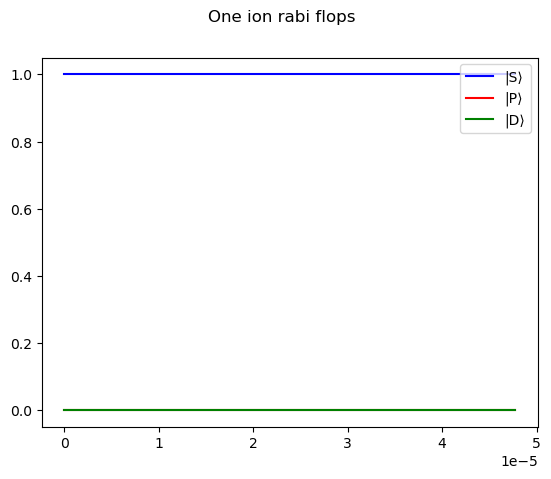

In [6]:
#=Now, we won't see any dynamics, because the lasers are far detuned from the transitions, so the interaction
picture isn't good enough. But the two-photon detuning is small, so maybe there is another frame we
could intelligently choose...?=#

slist = real(expect(ionprojector(my_trap,"S"),ρt))
plist = real(expect(ionprojector(my_trap,"P"),ρt))
dlist = real(expect(ionprojector(my_trap,"D"),ρt))
nlist = real(expect(one(ρi_ions)⊗IonSim.number(axial),ρt))

fig, (ax1) = plt.subplots(1)
fig.suptitle("One ion rabi flops")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,plist,color="red",label="|P⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
#ax2.plot(tspan,nlist,color="red",label="|n̄⟩")
ax1.legend(loc=1)
#ax2.legend(loc=1);

In [7]:
#= Now, we can try going into a rotating frame to reduce the time dependence and recover the dynamics we care
about even after making the RWA.=#
c = 2.99792458e8
#appropriate frame transformation for Λ-system Raman process
ν1 = 2π*(c/my_laser_1.λ + my_laser_1.Δ)
ν2 = 2π*(c/my_laser_2.λ + my_laser_2.Δ)

ϕ1 = 2π*(my_laser_2.Δ - my_laser_1.Δ)/2
ϕ2 = ϕ1 + ν1
ϕ3 = ϕ2 - ν2

u = [[(("S1/2",-1/2),-ϕ1),(("P3/2",-1/2),-ϕ2),(("D5/2",-1/2),-ϕ3)]]
h = hamiltonian(my_trap, rwa_cutoff=1e6, lamb_dicke_order=2, u=u);

In [8]:
#I have not yet implemented the H0 piece of the rotating frame Hamiltonian, so I am arbitrarily doing it here
h0 = (-ϕ1)*1e-6*dm(my_ion["S"])⊗dm(fockstate(axial, 0)) + (Δ)*1e-6*dm(my_ion["P"])⊗dm(fockstate(axial, 0)) + (ϕ1)*1e-6*dm(my_ion["D"])⊗dm(fockstate(axial, 0))
#h0 = (ωs+ϕ1)*1e-6*dm(my_ion["S"])⊗dm(fockstate(axial, 0)) + (ωp+ϕ2)*1e-6*dm(my_ion["P"])⊗dm(fockstate(axial, 0)) + (ωd+ϕ3)*1e-6*dm(my_ion["D"])⊗dm(fockstate(axial, 0))
function h1(t,ρ)
    return h0 + h(t,ρ)
end
Ω_eff = Ω₁*Ω₂/Δ
nflops = 2
τ = nflops/Ω_eff*1e6/π
steps = 1000
tspan = 0:τ/steps:τ
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h1(t, ρ), [J], [J], [γ]));

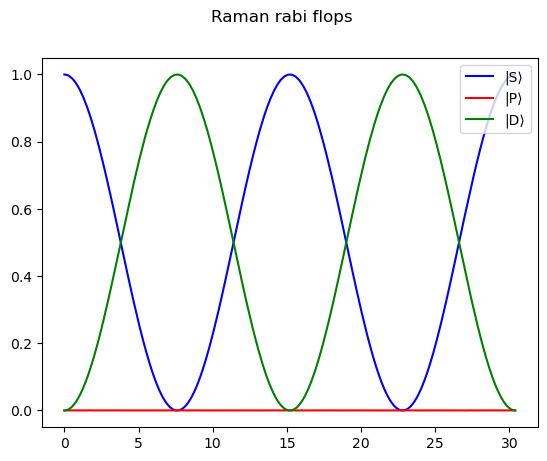

In [9]:
slist = real(expect(ionprojector(my_trap,"S"),ρt))
plist = real(expect(ionprojector(my_trap,"P"),ρt))
dlist = real(expect(ionprojector(my_trap,"D"),ρt))
nlist = real(expect(one(ρi_ions)⊗IonSim.number(axial),ρt))

fig, (ax1) = plt.subplots(1)
fig.suptitle("Raman rabi flops")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,plist,color="red",label="|P⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
#ax2.plot(tspan,nlist,color="red",label="|n̄⟩")
ax1.legend(loc=1)
#ax2.legend(loc=1);

In [12]:
dirname(pwd())

"/Users/justin/Julia"